## Feature Extraction

- CNN과 ViT 기반 모델들을 활용한 특징 추출

In [1]:
import pandas as pd
from torch.utils.data import DataLoader

df=pd.read_csv('data/metadata_with_Nan.csv') # read csv
names = set(list(df['Name'])) # remove duplicates
names = pd.DataFrame(names, columns=['Name']) # column name add

In [2]:
from tools.Fashiondataset import FashionDataset

image_folder = 'data/img_jpg' # set path
Dataset=FashionDataset(dataframe=names, image_folder=image_folder) # load unchange dataset
Dataloader=DataLoader(Dataset, batch_size=16, shuffle=False) # make dataloader

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
from tools.ExtractFeature import extract_features_from_images, get_features
from tools.clustering import perform_clustering_with_cache
import numpy as np

category_mapping = {
    'JK': 'Jacket', 
    'CT': 'Coat', 
    'JP': 'Jumper', 
    'KN': 'Knit', 
    'SW': 'Sweater', 
    'SH': 'Shirt', 
    'BL': 'Blouse', 
    'CD': 'Cardigan', 
    'VT': 'Vest', 
    'OP': 'One Piece', 
    'SK': 'Skirt', 
    'PT': 'Pants', 
    'SE': 'Shoes', 
    'BG': 'Bag', 
    'SC': 'Scarf', 
    'HC': 'Hat & Cap'
    }

Using Device: cuda


c:\Users\user\anaconda3\envs\general2\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


특징 추출

In [4]:
user_name='default' # set name for various user, default means default database
model = 'deit' # ['resnet', 'vit', 'dino', 'deit']
no_clusters=21 # set cluster number
force_ex = False # force to run and save model and features again

features = get_features(
    user_name, 
    model, 
    Dataloader, 
    force_extract=force_ex
    ) # extract features from model and save numpy

deit extracted feature load from saved/default_features_deit.npy.


## Bagging & Feature combination

- 정확도 향상을 위한 Bagging 사용
- 정확도 향상을 위한 카테고리명 특징 통합

In [5]:
"""dic={} # keeping data
for i in ['resnet', 'vit', 'dino', 'deit']: # set models
    temp=[]
    for j in range(5): # run 5 times
        temp.append(get_features(user_name+f'{j}', i, Dataloader, force_extract=True))

    dic[i]=temp"""

"dic={} # keeping data\nfor i in ['resnet', 'vit', 'dino', 'deit']: # set models\n    temp=[]\n    for j in range(5): # run 5 times\n        temp.append(get_features(user_name+f'{j}', i, Dataloader, force_extract=True))\n\n    dic[i]=temp"

In [6]:
"""for i in ['resnet', 'vit', 'dino', 'deit']: # bagging with arithmetic mean
    bagged_features = sum(dic[i])/5
    np.save(f'saved/{user_name}_bagged_{i}_feature.npy',bagged_features) # save bagged data
    print('done')"""

"for i in ['resnet', 'vit', 'dino', 'deit']: # bagging with arithmetic mean\n    bagged_features = sum(dic[i])/5\n    np.save(f'saved/{user_name}_bagged_{i}_feature.npy',bagged_features) # save bagged data\n    print('done')"

Bagging 모델 로드

In [7]:
features = np.load(f'saved/default_bagged_{model}_feature.npy') # load saved data

카테고리명 통합

In [8]:
from tools.module import enhance_features_with_category_weights_optimized

en_feature = enhance_features_with_category_weights_optimized(features, Dataset)

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
def reduce_dimensions(data, n_components=None, variance_ratio=0.90):

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    if n_components is None:
        pca_full = PCA()
        pca_full.fit(scaled_data)
        
        cumsum = np.cumsum(pca_full.explained_variance_ratio_)
        n_components = np.argmax(cumsum >= variance_ratio) + 1
        
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)
    
    return reduced_data, pca, pca.explained_variance_ratio_

core_en_feature, pca, _ = reduce_dimensions(en_feature)
print(core_en_feature.shape)

(7197, 298)


## Clustering

- Kmeans를 이용한 이미지 특징 클러스터링

In [35]:
# perform clustering and save model
labels, kmeans = perform_clustering_with_cache(
    user_name, 
    en_feature, 
    model_type=model, 
    n_clusters=no_clusters, 
    force_cluster=False
    )

default clustered labels were load from saved/default_labels_deit_21clusters.npy.
Model load from saved/default_deit_21clusters_model.pkl


## User input test

- 유저의 이미지를 이용해 의류 분류 및 유사도 체크

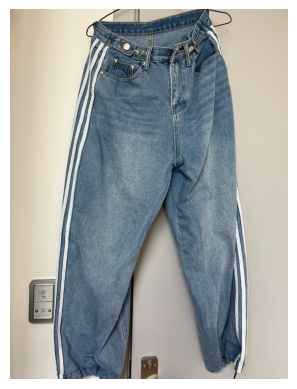

In [36]:
img_path = 'data/preference/PT1.jpg' # load sample input image
image = Image.open(img_path).convert('RGB')
plt.imshow(image) # show image
plt.axis('off') 
plt.show()

In [37]:
from tools.Extractor import FeatureExtractor
import torch
import warnings

warnings.filterwarnings('ignore', category=UserWarning) # erase warning

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device with gpu

# extract feature from input image
image_features = extract_features_from_images(
    [img_path], 
    FeatureExtractor(model_type=model).to(device), 
    device, 
    transform=False
    )
#image_features = pca.transform(image_features)
#print(image_features.shape)
warnings.resetwarnings()

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]


## Category classification

- 클러스터링 된 데이터셋에서 유저 사진이 포함되는 클러스터 예측

In [38]:
print("Labels loaded:", labels is not None)
print("Model loaded:", kmeans is not None)

predicted_cluster = kmeans.predict(image_features)[0] # predict input image
print(f"{img_path} clustered to {predicted_cluster}")

Labels loaded: True
Model loaded: True
data/preference/PT1.jpg clustered to 15


Representative images from Cluster 15
Image name: PT-697
Image name: PT-622
Image name: PT-216
Image name: PT-290
Image name: PT-564


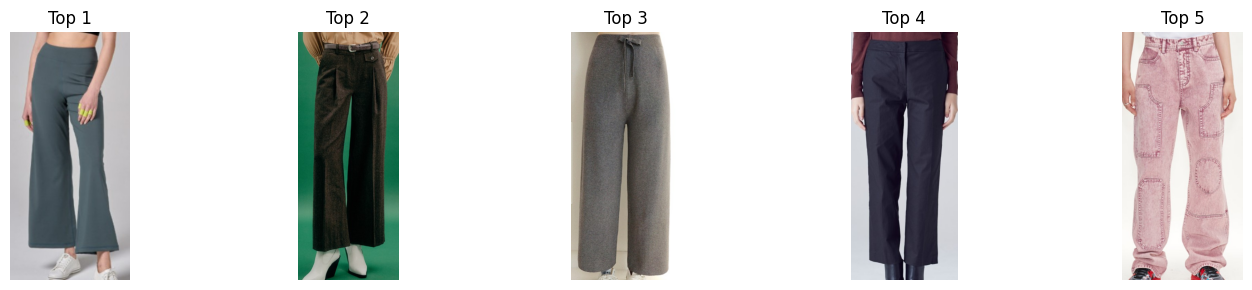

In [39]:
import numpy as np
from tools.clustering import show_cluster_images

# find the same clustered images from input image
show_cluster_images(
    Dataset, 
    labels, 
    cluster_num=predicted_cluster, 
    num_samples=5
    )

데이터셋 심볼을 명확한 이름으로 매핑

In [40]:
from tools.clustering import get_cluster_categories

cluster_categories = get_cluster_categories(
    Dataset, 
    kmeans, 
    en_feature, 
    labels,
    threshold=0.0
    )

# match cluster number with category name
cluster_names = {k: category_mapping.get(v, 'Unknown') for k, v in cluster_categories.items()}
print(cluster_names)

{np.int32(0): 'Blouse', np.int32(1): 'Bag', np.int32(2): 'Shoes', np.int32(3): 'Scarf', np.int32(4): 'Hat & Cap', np.int32(5): 'Sweater', np.int32(6): 'Jacket', np.int32(7): 'Knit', np.int32(8): 'Jumper', np.int32(9): 'Pants', np.int32(10): 'Coat', np.int32(11): 'Knit', np.int32(12): 'One Piece', np.int32(13): 'Jumper', np.int32(14): 'Cardigan', np.int32(15): 'Pants', np.int32(16): 'Hat & Cap', np.int32(17): 'Coat', np.int32(18): 'Shirt', np.int32(19): 'Skirt', np.int32(20): 'Skirt'}


In [41]:
from tools.clustering import compare_cluster_categories

analysis = compare_cluster_categories(cluster_names, category_mapping)

duplicates = analysis['duplicates']
missing = analysis['missing']

=== 클러스터 분석 ===

전체 카테고리 수: 16
현재 포함된 카테고리 수: 15
누락된 카테고리 수: 1

현재 카테고리 분포:
- Blouse: 1번
- Bag: 1번
- Shoes: 1번
- Scarf: 1번
- Hat & Cap: 2번
- Sweater: 1번
- Jacket: 1번
- Knit: 2번
- Jumper: 2번
- Pants: 2번
- Coat: 2번
- One Piece: 1번
- Cardigan: 1번
- Shirt: 1번
- Skirt: 2번

누락된 카테고리:
- Vest

중복된 카테고리:
- Hat & Cap: 2번 중복
- Knit: 2번 중복
- Jumper: 2번 중복
- Pants: 2번 중복
- Coat: 2번 중복
- Skirt: 2번 중복


## Similarity check

- 추출된 특징을 벡터화 하여 Cosine similarity 체크

In [16]:
from tools.similarity2 import Similarity

# set similarity vector field
sim = Similarity(
    feature_vectors=en_feature,
    dataset=Dataset,
    user_name=user_name,
    model_type=model,
    force_new=False
)

Saved index and vectors for user default
Saved new features for default



추천 결과:
2개의 유사도가 높은 아이템이 있습니다. 구매에 고려해주세요.

상위 5개 아이템 유사도:
1번째 아이템: 68.66000366210938%
2번째 아이템: 68.4000015258789%
3번째 아이템: 66.55000305175781%
4번째 아이템: 66.5%
5번째 아이템: 65.97000122070312%


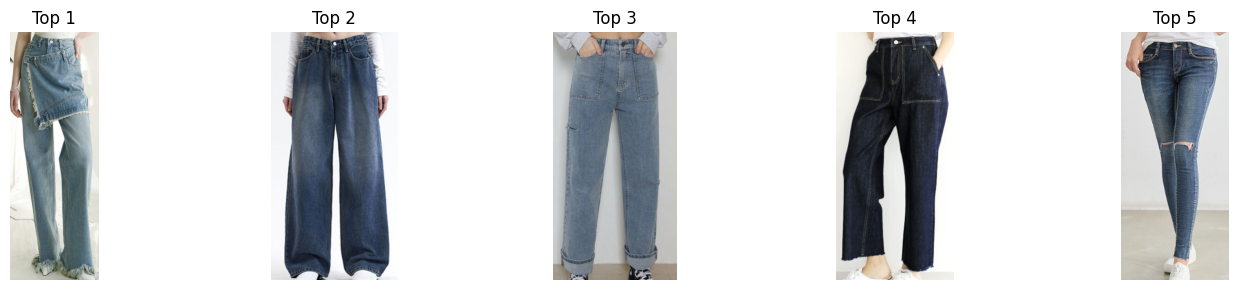

In [17]:
# find similarity top 5
a=sim.get_sim(image_features, k=5)[0]
# check buying attractiveness
percentages, recommendation = sim.attractiveness(image_features, return_percentage=True, custom_threshold=None)

print("\n추천 결과:")
print(recommendation)

print("\n상위 5개 아이템 유사도:")
for i, percent in enumerate(percentages[0][:5], 1):
    print(f"{i}번째 아이템: {percent}%")
Dataset.show_images(a)

## Recommend coordination

- 코디가 완료된 스타일 세트를 활용한 스타일 추천

In [18]:
from tools.module import get_image_paths

In [19]:
while True:
    Look = input("애슬래저:1, 캐주얼:2, 오피스:3, 페미닌:4 중 하나를 선택하세요: ")
    
    if Look == "1":
        path = 'Athlezer'
        break
    elif Look == "2":
        path = 'Casual'
        break
    elif Look == "3":
        path = 'Office'
        break
    elif Look == "4":
        path = 'Feminine'
        break
    else:
        print("잘못된 입력입니다. 1에서 4 사이의 숫자를 입력하세요.")

print(path+'이(가) 선택되었습니다.')

Office이(가) 선택되었습니다.


In [20]:
# feature extract from brand identity images

warnings.filterwarnings('ignore', category=UserWarning)

img_path = get_image_paths(f"data/{path}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
style_features = extract_features_from_images(img_path, FeatureExtractor(model_type=model).to(device), device, transform=True)

warnings.resetwarnings()

Feature Extraction: 100%|██████████| 17/17 [00:00<00:00, 134.79it/s]


In [21]:
# category check from clustering
labels, kmeans = perform_clustering_with_cache(user_name, en_feature, model_type=model, n_clusters=no_clusters)
print("Labels loaded:", labels is not None)
print("Model loaded:", kmeans is not None)

# predict category for brand images
predicted_cluster = kmeans.predict(style_features)
pred_label=[]
for i in predicted_cluster:
    pred_label.append(cluster_names[i])
print(pred_label)

default clustered labels were load from saved/default_labels_deit_21clusters.npy.
Model load from saved/default_deit_21clusters_model.pkl
Labels loaded: True
Model loaded: True
['Jacket', 'Pants', 'Shoes', 'Bag', 'Jacket', 'Skirt', 'Shoes', 'Jacket', 'Shoes', 'Coat', 'Shoes', 'Coat', 'Shoes', 'Jacket', 'Jacket', 'Shoes', 'Bag']


In [22]:
from tools.recommend import debug_style_items, create_style_clothing_matrix
# RUN ONE TIME WHEN THERE ARE NO META DATA
run=False

if run:
    debug_style_items(img_path, pred_label)

    df = create_style_clothing_matrix(img_path, pred_label, cluster_names)

    print("\n=== 최종 결과 ===")
    print("스타일별 의류 개수:")
    clothing_counts = df.iloc[:, 1:].apply(lambda x: x.str.len() > 0).sum(axis=1)
    for style, count in zip(df['style'], clothing_counts):
        print(f"스타일 {style}: {int(count)}개 의류 보유")

    print("\n스타일별 보유 의류:")
    for idx, row in df.iterrows():
        style = row['style']
        print(f"\n스타일 {style}:")
        for col in df.columns[1:]:
            if row[col]:
                print(f"  - {col}: {row[col]}")

    df.to_csv(f'data/{path}/clothing_matrix_{path}.csv', index=False)

In [ ]:
import os
from tools.recommend import get_random_style_images

try:
    style_num, image_paths, categories = get_random_style_images(f'data/{path}/clothing_matrix_{path}.csv', f'data/{path}')
    print("\n추출된 이미지 경로:")
    for pth in image_paths:
        print(f"- {pth}")

    print("\n파일 존재 확인:")
    for pth in image_paths:
        exists = os.path.exists(pth)
        print(f"- {os.path.basename(pth)}: {'존재함' if exists else '존재하지 않음'}")
except Exception as e:
    print(f"오류 발생: {str(e)}")

    print("\nCSV 파일 내용 확인:")
    df = pd.read_csv(f'data/{path}/clothing_matrix.csv')
    print("\n데이터프레임 정보:")
    print(df.info())
    print("\n첫 몇 개의 행:")
    print(df.head())
    print("\n데이터 타입:")
    print(df.dtypes)

선택된 스타일: 5
포함된 의류 종류:
- Shoes: 5-2.jpg
- Coat: 5-1.jpg

추출된 이미지 경로:
- data/Office\5-2.jpg
- data/Office\5-1.jpg

파일 존재 확인:
- 5-2.jpg: 존재함
- 5-1.jpg: 존재함


In [24]:
print(categories)

['Shoes', 'Coat']


In [25]:
print(path)

Office


In [26]:
# similarity check with brand image and existing closet database
sim2 = Similarity(
    feature_vectors=en_feature,
    dataset=Dataset,
    user_name=f'{path}_style_{style_num}',
    user_vector=None,
    model_type=model,
    force_new=False
)
style_features=[]
for img in image_paths:
    style_features.append(extract_features_from_images([img], FeatureExtractor(model_type=model).to(device), device, transform=True))

Saved index and vectors for user Office_style_5
Saved new features for Office_style_5


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 110.93it/s]


In [ ]:
# extract feature from brand images
style_features2=extract_features_from_images(image_paths, FeatureExtractor(model_type=model).to(device), device, transform=True)

Feature Extraction: 100%|██████████| 2/2 [00:00<00:00, 112.36it/s]


Shoes Shoes
Coat Coat


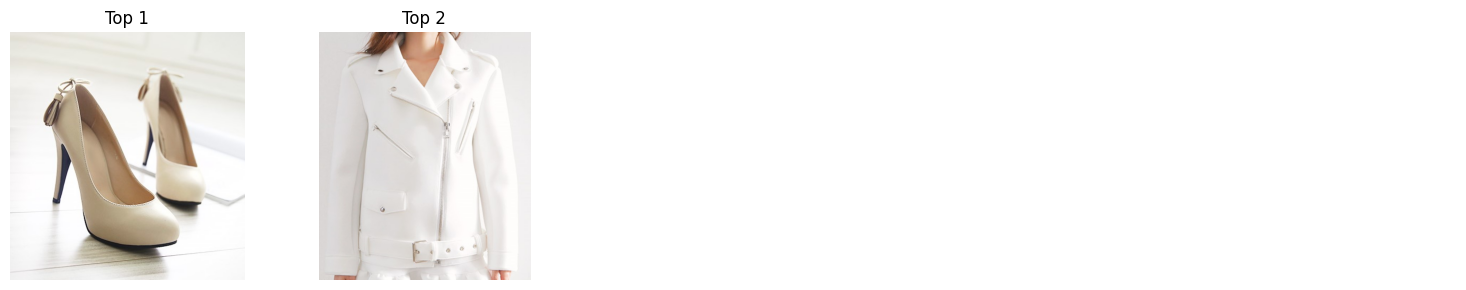

In [ ]:
from tools.recommend import categorize_item
recommend_indices = []
ind=0
for feature in style_features2:
    feature_reshaped = feature.reshape(1, -1)
    indices, indice_feature = sim2.get_sim(feature_reshaped, k=15)
    indice_filter = []

    for j in range(len(indices)):
        chk = cluster_names[kmeans.predict(indice_feature[j].reshape(1, -1))[0]]
        if categorize_item(chk) == categorize_item(categories[ind]):
            print(chk, categories[ind])
            indice_filter.append(indices[j])
            break
    
    ind += 1
    
    recommend_indices.extend(indice_filter)
Dataset.show_images(recommend_indices)

## Check clustering

- Elbow method를 활용한 실제 kmeans centroid 최적 개수 추측
- PCA를 활용한 차원 축소 및 데이터 구조 이해를 위한 3D 그래프
- Scree plot을 활용한 70, 80, 90 퍼센트 variance 구간 탐색

Elbow Method

Testing k=10
Testing k=11
Testing k=12
Testing k=13
Testing k=14
Testing k=15
Testing k=16
Testing k=17
Testing k=18
Testing k=19
Testing k=20
Testing k=21
Testing k=22
Testing k=23
Testing k=24
Testing k=25
Testing k=26
Testing k=27
Testing k=28
Testing k=29
Testing k=30


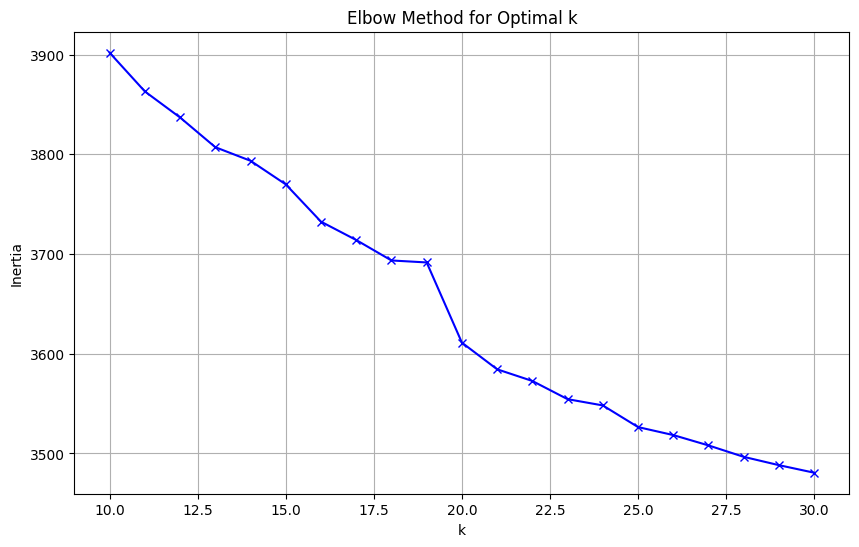

최적의 클러스터 수: 16


In [42]:
from tools.module import visualize_in_3d_with_scree_plot, find_optimal_clusters
optimal_k = find_optimal_clusters(en_feature)

PCA Analysis & Scree Plot

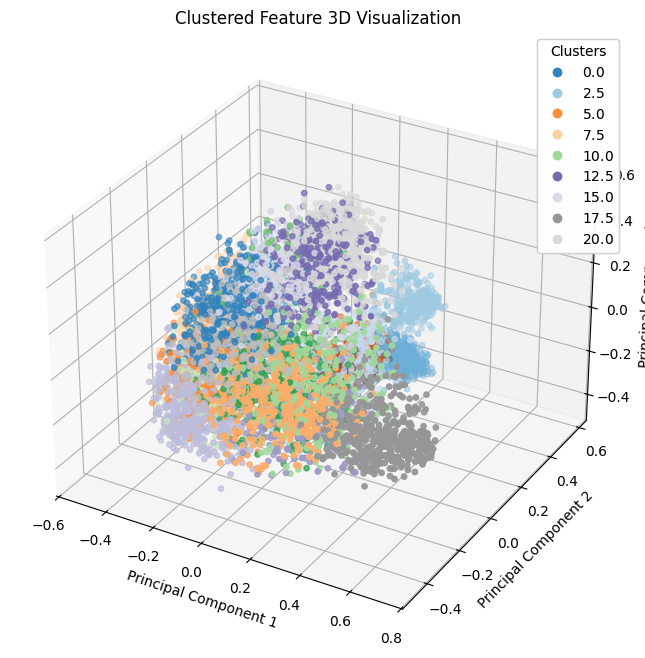

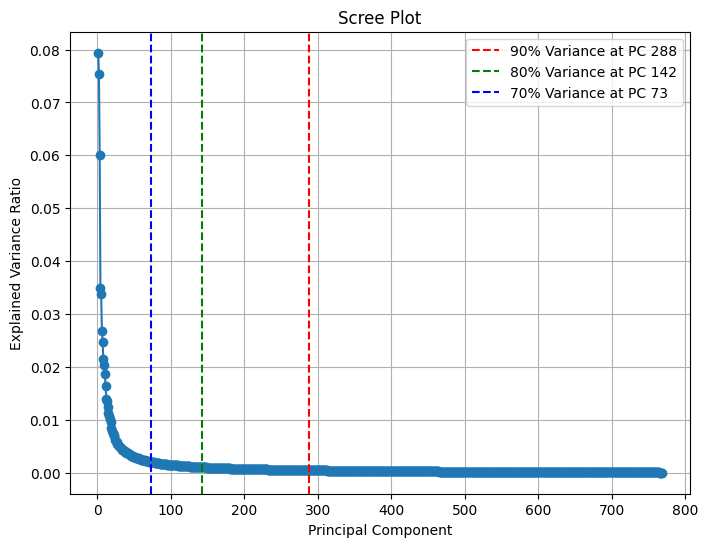

In [43]:
visualize_in_3d_with_scree_plot(en_feature,labels)